In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-06-14 18:53:54.608550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 18:53:54.608671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 18:53:54.755221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Getting the Arabic stopwords from NLTK
stop_words = set(stopwords.words('arabic'))

### **AFND Dataset**

In [3]:
# Specify the path to your dataset directory
dataset_dir = "/kaggle/input/arabic-fake-news-dataset-afnd/AFND/Dataset"

In [4]:
# Read sources.json
sources_file_path = '/kaggle/input/arabic-fake-news-dataset-afnd/AFND/sources.json'
with open(sources_file_path, 'r', encoding='utf-8') as sources_file:
    sources_data = json.load(sources_file)
sources_df = pd.DataFrame(list(sources_data.items()), columns=['source', 'label'])

In [5]:
# Read scraped_articles.json for each source
articles_data = []

for source in sources_df['source']:
    scraped_articles_path = os.path.join(dataset_dir, source, 'scraped_articles.json')
    
    # Check if the file exists before attempting to read it
    if os.path.exists(scraped_articles_path):
        with open(scraped_articles_path, 'r', encoding='utf-8') as articles_file:
            source_articles_dict = json.load(articles_file)
            source_articles_list = source_articles_dict.get("articles", [])
            
            # Add a 'source' key to each article
            for article in source_articles_list:
                article['source'] = source
            
            articles_data.extend(source_articles_list)

# Convert articles_data to a DataFrame
articles_df = pd.DataFrame(articles_data)

In [6]:
# Merge the articles with their sources(labels)
merged_df = pd.merge(articles_df, sources_df, how='inner', left_on='source', right_on='source')

In [7]:
merged_df.head()

,title,text,published date,source,label
0,المنتخب الوطني المغربي لأقل من 20 سنة يخوض تجم...,يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...,2021-05-23T00:00:00,source_1,credible
1,وزير النقل اعمارة:السرعة عامل مسبب لحوادث السي...,ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...,2021-05-22T00:00:00,source_1,credible
2,"ميسي يؤكد أن الفوز بكأس اسبانيا كان ""نقطة تحول""",أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...,2021-05-22T00:00:00,source_1,credible
3,دبلوماسي مغربي سابق بإسبانيا لـ2M.ma: خطأ مدري...,أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...,2021-05-22T00:00:00,source_1,credible
4,شركتان، فرنسية وبريطانية تعلنان عن نتائج إيجاب...,أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...,2021-05-17T00:00:00,source_1,credible


In [8]:
merged_df.shape

(606912, 5)

Text(0, 0.5, '# of Articles')

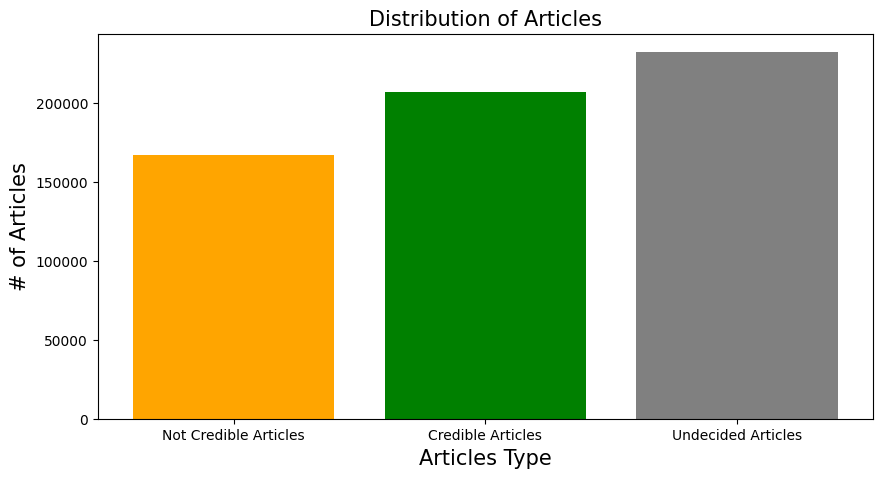

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Not Credible Articles', len(merged_df[merged_df['label'] == 'not credible']), color='orange')
plt.bar('Credible Articles', len(merged_df[merged_df['label'] == 'credible']), color='green')
plt.bar('Undecided Articles', len(merged_df[merged_df['label'] == 'undecided']), color='gray')
plt.title('Distribution of Articles', size=15)
plt.xlabel('Articles Type', size=15)
plt.ylabel('# of Articles', size=15)

### **Gaza Dataset**

In [10]:
# Define the directory containing the Gaza dataset
gaza_dataset_dir = "/kaggle/input/gaza-dataset/gaza_dataset/Dataset"

# Read the sources.json file
gaza_sources_file_path = '/kaggle/input/gaza-dataset/gaza_dataset/sources.json'
with open(gaza_sources_file_path, 'r', encoding='utf-8') as gaza_sources_file:
    gaza_sources_data = json.load(gaza_sources_file)
gaza_sources_df = pd.DataFrame(list(gaza_sources_data['root'].items()), columns=['source', 'label'])


In [11]:
# Read scraped_articles.json for each source
gaza_articles_data = []

for gaza_source in gaza_sources_df['source']:
    gaza_scraped_articles_path = os.path.join(gaza_dataset_dir, gaza_source, 'scraped_articles.json')
    
    # Check if the file exists before attempting to read it
    if os.path.exists(gaza_scraped_articles_path):
        with open(gaza_scraped_articles_path, 'r', encoding='utf-8') as gaza_articles_file:
            gaza_source_articles_dict = json.load(gaza_articles_file)
            gaza_source_articles_list = gaza_source_articles_dict['root'].get("articles", [])
            
            # Add a 'source' key to each article
            for gaza_article in gaza_source_articles_list:
                gaza_article['source'] = gaza_source
            
            gaza_articles_data.extend(gaza_source_articles_list)

# Convert articles_data to a DataFrame
gaza_articles_df = pd.DataFrame(gaza_articles_data)

In [12]:
# Merge the articles with their sources(labels)
new_merged_df = pd.merge(gaza_articles_df, gaza_sources_df, how='inner', on='source')

# Reorder the columns to match the specified format
new_merged_df = new_merged_df[['title', 'text', 'published date', 'source', 'label']]

In [13]:
new_merged_df.head()

,title,text,published date,source,label
0,"صحفيو غزة: ""أهداف"" أم ""خسائر"" في الحرب الإسرائ...",يُقتل الصحفيون في غزة بمعدل غير مسبوق. بالإضاف...,23-12-2023,source_1,credible
1,"إسرائيل تأمر بإخلاء ""ممر الموت"" للفلسطينيين في...",واضطر مئات الفلسطينيين إلى إخلاء مخيمي البريج ...,23-12-2023,source_1,credible
2,حرب إسرائيل على غزة: قائمة الأحداث الرئيسية، ا...,مجلس الأمن التابع للأمم المتحدة يصدر قرارًا لت...,23-12-2023,source_1,credible
3,وتتهم الولايات المتحدة إيران بالتورط بشكل عميق...,ويقول البيت الأبيض إن طهران تزود جماعة متمردة ...,23-12-2023,source_1,credible
4,وتواصل القوات الإسرائيلية هجماتها وسط انتقادات...,وقد تعرض القرار المخفف لتعزيز المساعدات لغزة ل...,23-12-2023,source_1,credible


In [14]:
new_merged_df.shape

(3338, 5)

Text(0, 0.5, '# of Articles')

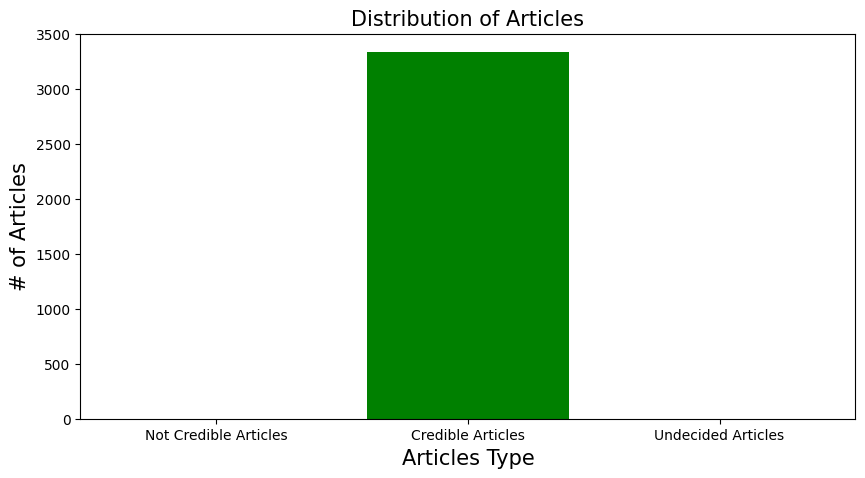

In [15]:
plt.figure(figsize=(10, 5))
plt.bar('Not Credible Articles', len(new_merged_df[new_merged_df['label'] == 'not credible']), color='orange')
plt.bar('Credible Articles', len(new_merged_df[new_merged_df['label'] == 'credible']), color='green')
plt.bar('Undecided Articles', len(new_merged_df[new_merged_df['label'] == 'undecided']), color='gray')
plt.title('Distribution of Articles', size=15)
plt.xlabel('Articles Type', size=15)
plt.ylabel('# of Articles', size=15)

### **Combining Datasets**

In [16]:
# Combine the two datasets
combined_dataset = pd.concat([new_merged_df, merged_df], ignore_index=True)

# Display the combined dataset
combined_dataset

,title,text,published date,source,label
0,"صحفيو غزة: ""أهداف"" أم ""خسائر"" في الحرب الإسرائ...",يُقتل الصحفيون في غزة بمعدل غير مسبوق. بالإضاف...,23-12-2023,source_1,credible
1,"إسرائيل تأمر بإخلاء ""ممر الموت"" للفلسطينيين في...",واضطر مئات الفلسطينيين إلى إخلاء مخيمي البريج ...,23-12-2023,source_1,credible
2,حرب إسرائيل على غزة: قائمة الأحداث الرئيسية، ا...,مجلس الأمن التابع للأمم المتحدة يصدر قرارًا لت...,23-12-2023,source_1,credible
3,وتتهم الولايات المتحدة إيران بالتورط بشكل عميق...,ويقول البيت الأبيض إن طهران تزود جماعة متمردة ...,23-12-2023,source_1,credible
4,وتواصل القوات الإسرائيلية هجماتها وسط انتقادات...,وقد تعرض القرار المخفف لتعزيز المساعدات لغزة ل...,23-12-2023,source_1,credible
...,...,...,...,...,...
610245,إجراءات إيطالية صارمة ضد الجماهير الإنقليزية,شدد مسؤول إيطالي اليوم الأربعاء على ضرورة التز...,2021-06-30T11:55:00,source_134,credible
610246,الأزهر يحذّر من لعبة ''فورتنايت'',حذّر مركز الأزهر العالمي للفتوى الإلكرتونية، م...,2021-06-30T15:52:00,source_134,credible
610247,يورو 2020: بوتين يدافع عن استضافة مباريات في س...,دافع الرئيس الروسي فلاديمير بوتين عن استضافة م...,2021-06-30T15:07:00,source_134,credible
610248,ميركل تشعر بخيبة أمل بعد خروج منتخبها الوطني م...,"شعرت المستشارة الألمانية أنجيلا ميركل ""بخيبة أ...",2021-06-30T14:58:00,source_134,credible


Text(0, 0.5, '# of Articles')

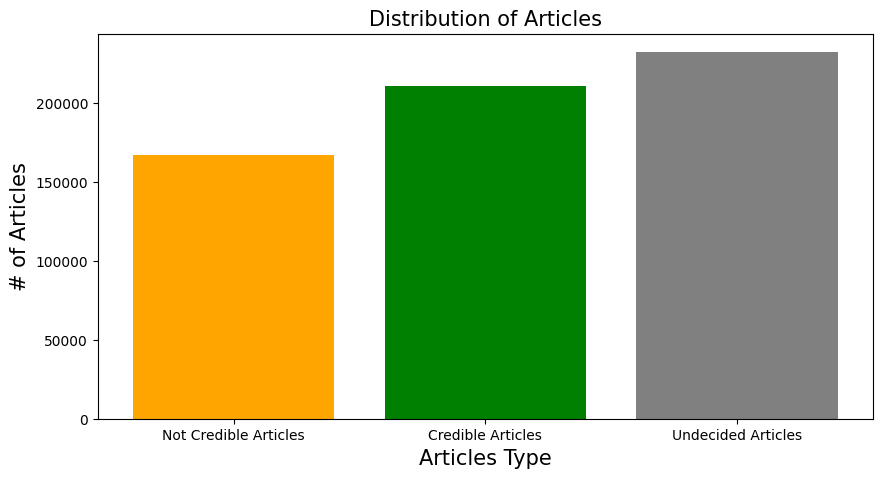

In [17]:
plt.figure(figsize=(10, 5))
plt.bar('Not Credible Articles', len(combined_dataset[combined_dataset['label'] == 'not credible']), color='orange')
plt.bar('Credible Articles', len(combined_dataset[combined_dataset['label'] == 'credible']), color='green')
plt.bar('Undecided Articles', len(combined_dataset[combined_dataset['label'] == 'undecided']), color='gray')
plt.title('Distribution of Articles', size=15)
plt.xlabel('Articles Type', size=15)
plt.ylabel('# of Articles', size=15)

### **Pre-processing Data**

In [18]:
# Data Preparation
X = combined_dataset['text']
y = combined_dataset['label']

In [19]:
# Remove Arabic stopwords
X = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

In [20]:
# Use LabelEncoder to convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [22]:
# Tokenization and Padding
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [23]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [24]:
max_sequence_length = 128   # Set an appropriate value
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

### **LSTM**

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import tensorflow as tf
import numpy as np

# Assuming max_sequence_length and tokenizer are already defined
max_sequence_length = 128
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units=len(np.unique(y_encoded)), activation='softmax'))

# Build the model
model.build(input_shape=(None, max_sequence_length))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Print the model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 100)       │   182,524,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 128, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,599,759 (696.56 MB)

 Trainable params: 182,599,759 (696.56 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, batch_size=64, shuffle=True, callbacks=[early_stop])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 182524300 elements. This may consume a large amount of memory.
  warnings.warn(


6103/6103 ━━━━━━━━━━━━━━━━━━━━ 370s 60ms/step - accuracy: 0.4720 - loss: 1.0102 - val_accuracy: 0.5978 - val_loss: 0.8433
Epoch 2/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 377s 59ms/step - accuracy: 0.6141 - loss: 0.8190 - val_accuracy: 0.6382 - val_loss: 0.7737
Epoch 3/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 363s 59ms/step - accuracy: 0.6487 - loss: 0.7644 - val_accuracy: 0.6494 - val_loss: 0.7648
Epoch 4/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 363s 59ms/step - accuracy: 0.6674 - loss: 0.7373 - val_accuracy: 0.6688 - val_loss: 0.7295
Epoch 5/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 364s 60ms/step - accuracy: 0.6956 - loss: 0.6852 - val_accuracy: 0.6818 - val_loss: 0.7020
Epoch 6/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 381s 59ms/step - accuracy: 0.7030 - loss: 0.6663 - val_accuracy: 0.6894 - val_loss: 0.6893
Epoch 7/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 363s 59ms/step - accuracy: 0.7131 - loss: 0.6450 - val_accuracy: 0.6864 - val_loss: 0.6891
Epoch 8/10
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 364s 60ms/step - accuracy: 0.7204 - lo

In [27]:
# Save the model
model.save('lstm_model.h5')

In [28]:
# Evaluate the Model
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

3815/3815 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
Test Accuracy: 0.6971


In [29]:
# Evaluate other metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73     41874
           1       0.63      0.60      0.61     33534
           2       0.71      0.74      0.73     46642

    accuracy                           0.70    122050
   macro avg       0.69      0.69      0.69    122050
weighted avg       0.70      0.70      0.70    122050



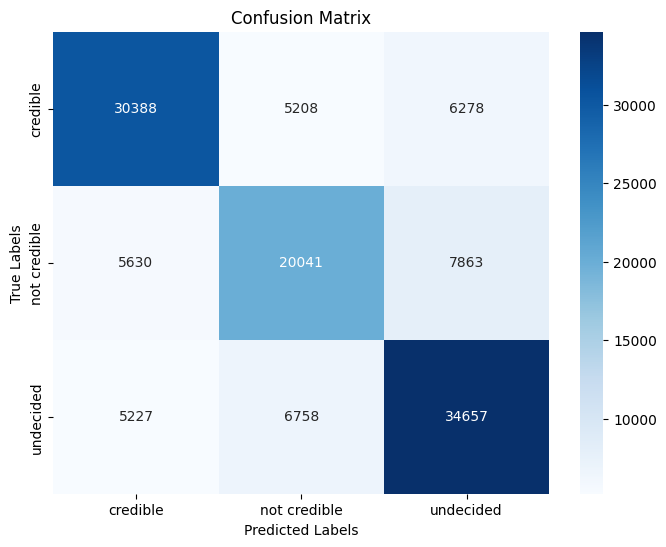

In [30]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **Naive Bayes**

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


# Naive Bayes Model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Test Accuracy: {accuracy_nb:.4f}")
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Test Accuracy: 0.5657
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59     41874
           1       0.55      0.34      0.42     33534
           2       0.57      0.68      0.62     46642

    accuracy                           0.57    122050
   macro avg       0.56      0.55      0.54    122050
weighted avg       0.56      0.57      0.56    122050



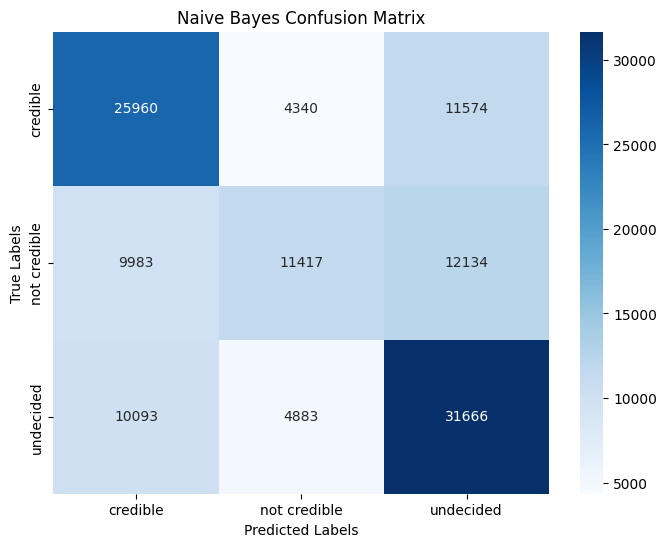

In [32]:
# Confusion Matrix for Naive Bayes Model
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

### **SVM**

In [33]:
from sklearn.svm import LinearSVC
# SVM Model
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Test Accuracy: {accuracy_svm:.4f}")
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Test Accuracy: 0.6719
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70     41874
           1       0.65      0.50      0.56     33534
           2       0.66      0.76      0.71     46642

    accuracy                           0.67    122050
   macro avg       0.67      0.66      0.66    122050
weighted avg       0.67      0.67      0.67    122050



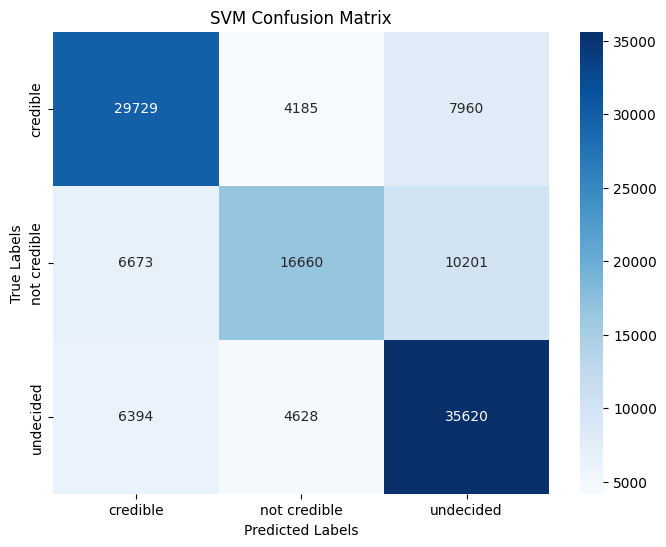

In [34]:
# Confusion Matrix for SVM Model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()